# Forecast the Airline Passenger data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

# Work Flow
1. Import Libraries
2. Load the data
3. EDA
4. Preprocessing
5. Split the dataset
6. Build the model
7. Model Selection
8. Conclusion

In [40]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Models
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_excel('Airlines+Data.xlsx')

In [3]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
df.shape

(96, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


* There is no null values are present in this dataset
* Date column have right datatype.

In [6]:
df.set_index('Month', inplace=True)

In [7]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [8]:
df = df.asfreq('MS')

In [9]:
df.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01', '1995-11-01', '1995-12-01',
               '1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01', '1997-11-01', '1997-12-01',
               '1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01',
               '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01',
               '1998-09-01', '1998-10-01', '1998-11-01', '1998-12-01',
               '1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
      

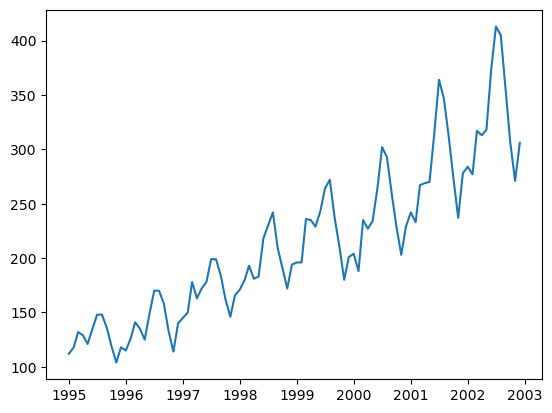

In [14]:
plt.plot(df)
plt.show()

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

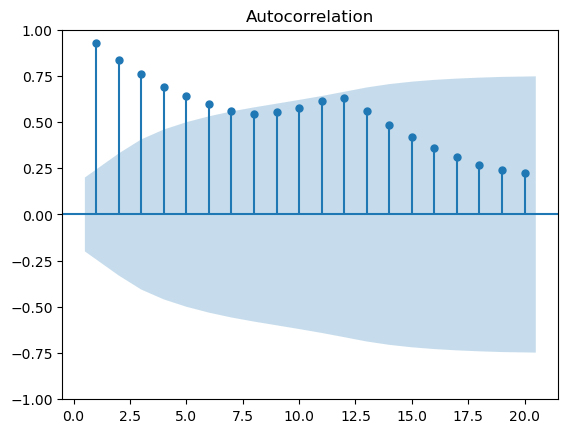

In [16]:
plot_acf(df, zero=False);

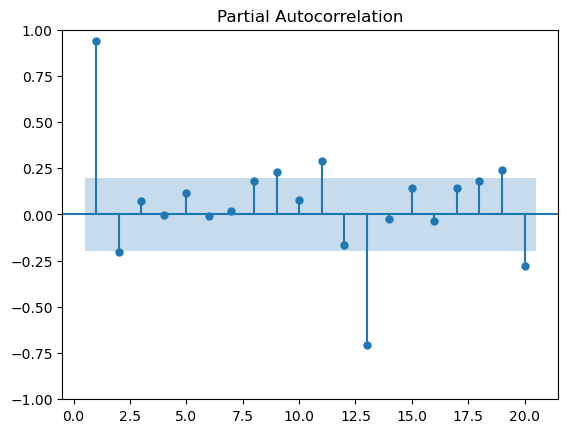

In [17]:
plot_pacf(df, zero=False);

## ETS Decomposition

In [18]:
from statsmodels.tsa.seasonal import STL

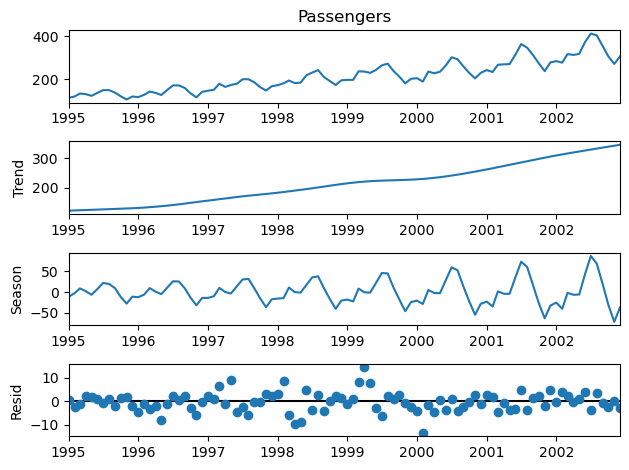

In [19]:
res = STL(df['Passengers']).fit()
res.plot()
plt.show()

* We can see there is trend in dataset.

## Check for stationary

In [20]:
from statsmodels.tsa.stattools import adfuller 

In [21]:
def ad_test(df,col):
    p_value = adfuller(df[col])[0]
    if p_value >= 0.05:
        print('Not Stationary')
    else:
        print('Stationary')

In [22]:
ad_test(df,'Passengers')

Not Stationary


## Let's remove the trend

In [23]:
df['diff_1'] = df['Passengers']-df['Passengers'].shift(1)

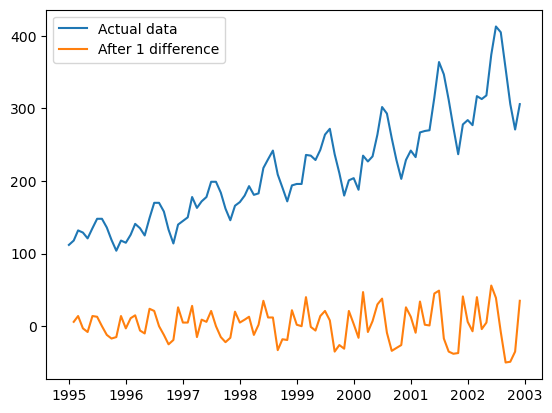

In [24]:
plt.plot(df['Passengers'],label='Actual data')
plt.plot(df['diff_1'], label = 'After 1 difference')
plt.legend()
plt.show()

In [25]:
df['diff_2'] = df['diff_1']-df['diff_1'].shift(1)

In [26]:
df.head()

,Passengers,diff_1,diff_2
Month,,,
1995-01-01,112,NaN,NaN
1995-02-01,118,6.0,NaN
1995-03-01,132,14.0,8.0
1995-04-01,129,-3.0,-17.0
1995-05-01,121,-8.0,-5.0


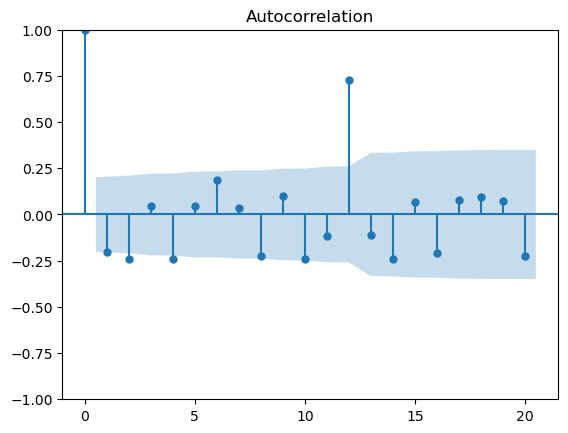

In [27]:
plot_acf(df['diff_2'].dropna());

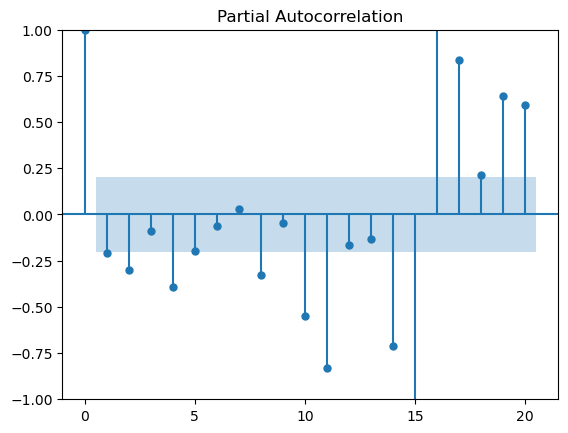

In [28]:
plot_pacf(df['diff_2'].dropna());

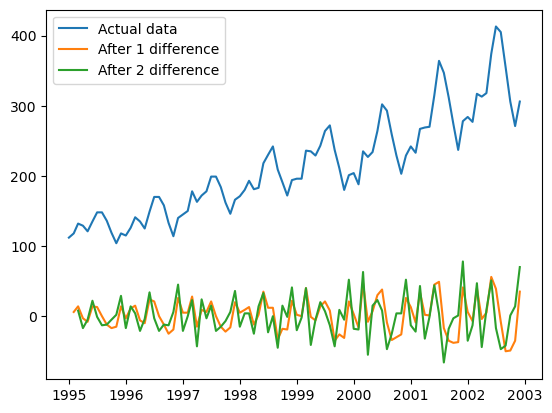

In [29]:
plt.plot(df['Passengers'],label='Actual data')
plt.plot(df['diff_1'], label = 'After 1 difference')
plt.plot(df['diff_2'], label = 'After 2 difference')
plt.legend()
plt.show()

## ETS Decomposition

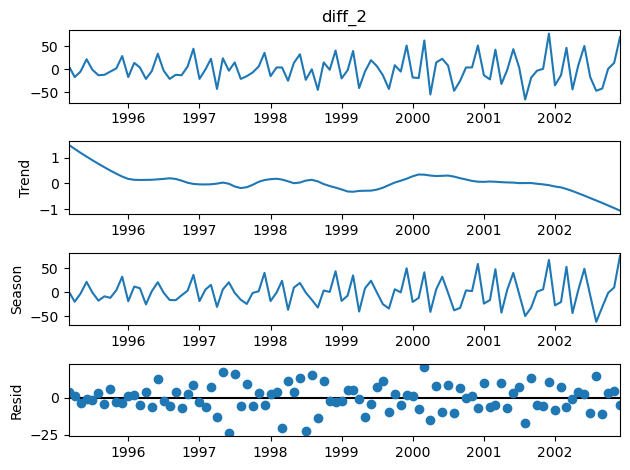

In [30]:
res = STL(df['diff_2'].dropna()).fit()
res.plot()
plt.show()

* Now there is no seasonality and no trend in the dataset.

In [31]:
df.fillna(method='bfill', inplace=True)

In [32]:
train_len = int(len(df)*0.75)
train_len

72

In [33]:
train_df_pas = df.iloc[:train_len,0]
test_df_pas = df.iloc[train_len:,0]

In [34]:
train_df_diff_1 = df.iloc[:train_len,1]
test_df_diff_1 = df.iloc[train_len:,1]

In [35]:
train_df_diff_2 = df.iloc[:train_len,2]
test_df_diff_2 = df.iloc[train_len:,2]

# 5. Let's Build the model

## 5.1. AR Model

In [41]:
from statsmodels.tsa.ar_model import AutoReg

In [42]:
model = AutoReg(train_df_pas, lags=3).fit()
pred = model.predict(start=train_len, end=len(df)-1)

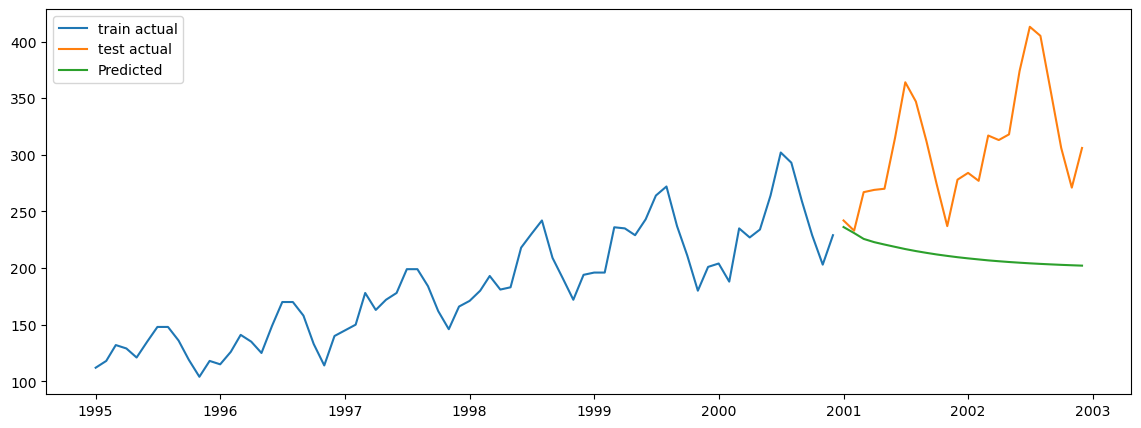

In [43]:
plt.figure(figsize=(14,5))
plt.plot(train_df_pas, label='train actual')
plt.plot(test_df_pas, label='test actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

In [45]:
mae_ar_actual = mean_absolute_error(test_df_pas, pred)
rmse_ar_actual = np.sqrt(mean_squared_error(test_df_pas, pred))
mae_ar_actual, rmse_ar_actual

(94.04578822919518, 108.47602043785298)

In [46]:
model = AutoReg(train_df_diff_1, lags=3).fit()
pred = model.predict(start=train_len, end=len(df)-1)

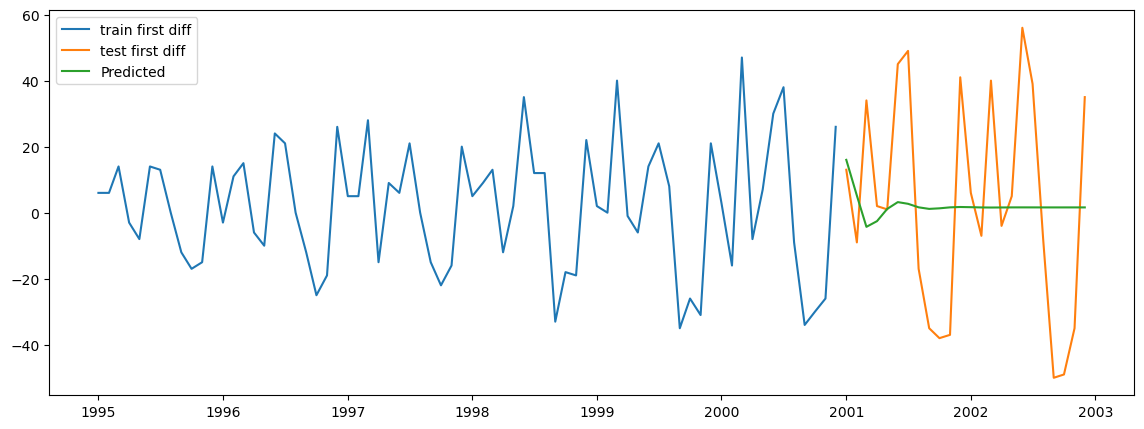

In [47]:
plt.figure(figsize=(14,5))
plt.plot(train_df_diff_1, label='train first diff')
plt.plot(test_df_diff_1, label='test first diff')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

In [50]:
mae_ar_diff_1 = mean_absolute_error(test_df_diff_1, pred)
rmse_ar_diff_1 = np.sqrt(mean_squared_error(test_df_diff_1, pred))
mae_ar_diff_1, rmse_ar_diff_1

(27.257209665035987, 32.63478309300941)

In [40]:
model = AutoReg(train_df_diff_2, lags=3).fit()
pred = model.predict(start=train_len, end=len(df)-1)

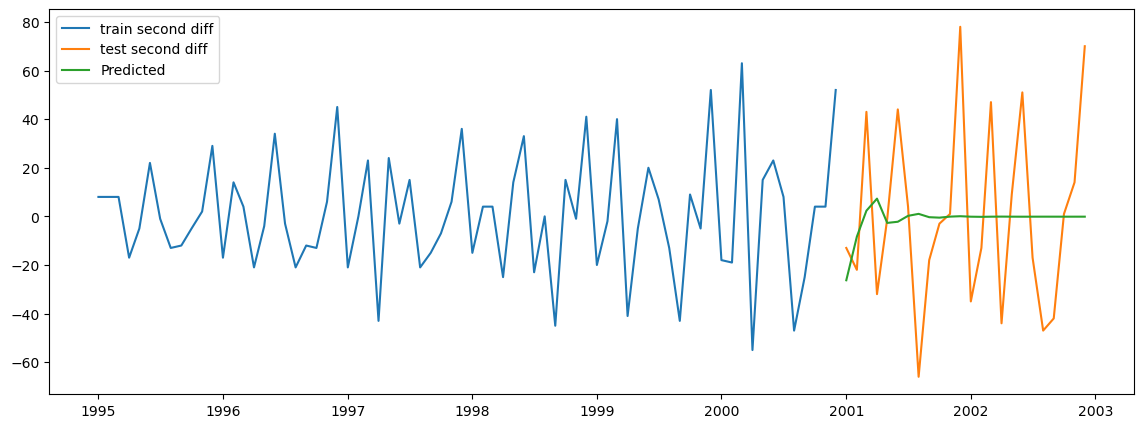

In [41]:
plt.figure(figsize=(14,5))
plt.plot(train_df_diff_2, label='train second diff')
plt.plot(test_df_diff_2, label='test second diff')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

In [51]:
mae_ar_diff_2 = mean_absolute_error(test_df_diff_2, pred)
rmse_ar_diff_2 = np.sqrt(mean_squared_error(test_df_diff_2, pred))
mae_ar_diff_2, rmse_ar_diff_2

(30.68243516275939, 38.05918604622538)

# AUTO_ARIMA

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [44]:
stepwise_fit = auto_arima(df['Passengers'], start_p = 1, start_q = 1,
                          max_p = 6, max_q = 6, m = 5,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',    # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=972.497, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=870.682, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=975.139, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=895.644, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=865.836, Time=0.29 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=910.405, Time=0.19 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=831.813, Time=0.34 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=849.799, Time=0.20 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=833.785, Time=0.44 sec
 ARIMA

In [45]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   96
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 5)   Log Likelihood                -398.823
Date:                           Mon, 10 Jul 2023   AIC                            813.646
Time:                                   19:30:08   BIC                            833.733
Sample:                               01-01-1995   HQIC                           821.750
                                    - 12-01-2002                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.1507      1.550      4.614      0.000       4.113      10.189
ar.L1          1.6935      0.035     48.097      0.000       1.624       1.762
ar.L2         -0.9616      0.037    -25.664      0.000      -1.035      -0.888
ma.L1         -0.7812      0.086     -9.035      0.000      -0.951      -0.612
ar.S.L5       -0.6990      0.142     -4.920      0.000      -0.977      -0.421
ar.S.L10      -0.5551      0.122     -4.563      0.000      -0.794      -0.317
ma.S.L5        0.8072      0.107      7.548      0.000       0.598       1.017
sigma2       331.3780     60.043      5.519      0.000     213.696     449.060
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                10.80
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5.2 ARIMA

In [46]:
model = ARIMA(train_df_pas, order=(2,1,2)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

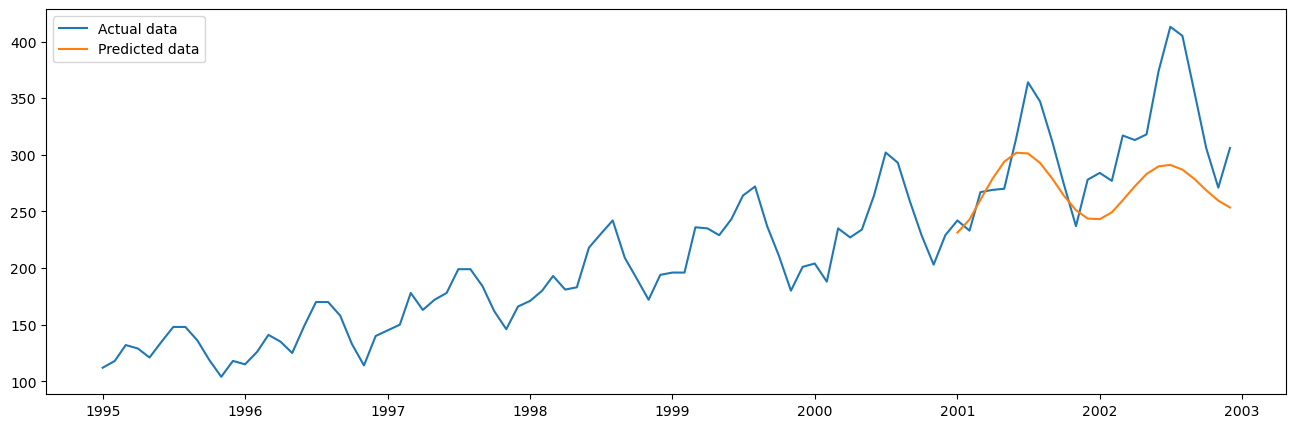

In [47]:
plt.figure(figsize=(16,5))
plt.plot(df['Passengers'],label='Actual data')
plt.plot(pred, label='Predicted data')
plt.legend()
plt.show()

In [54]:
mae_arima_actual = mean_absolute_error(test_df_pas,pred)
rmse_arima_actual = np.sqrt(mean_squared_error(test_df_pas, pred))
mae_arima_actual, rmse_arima_actual

(304.12665794407457, 308.08512202146653)

In [55]:
residuals = test_df_pas - pred

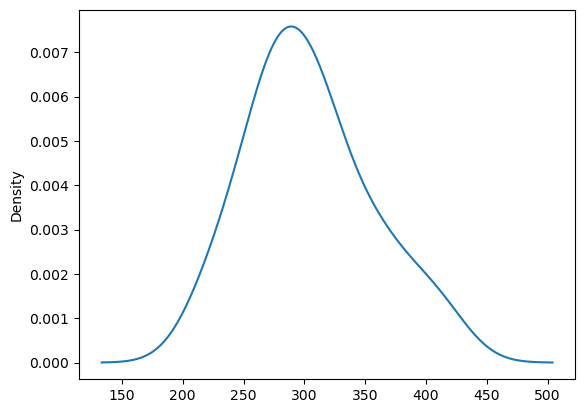

In [56]:
residuals.plot(kind='kde')
plt.show()

* Residual is normally disributed.

In [57]:
model = ARIMA(train_df_diff_1, order=(2,1,2)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

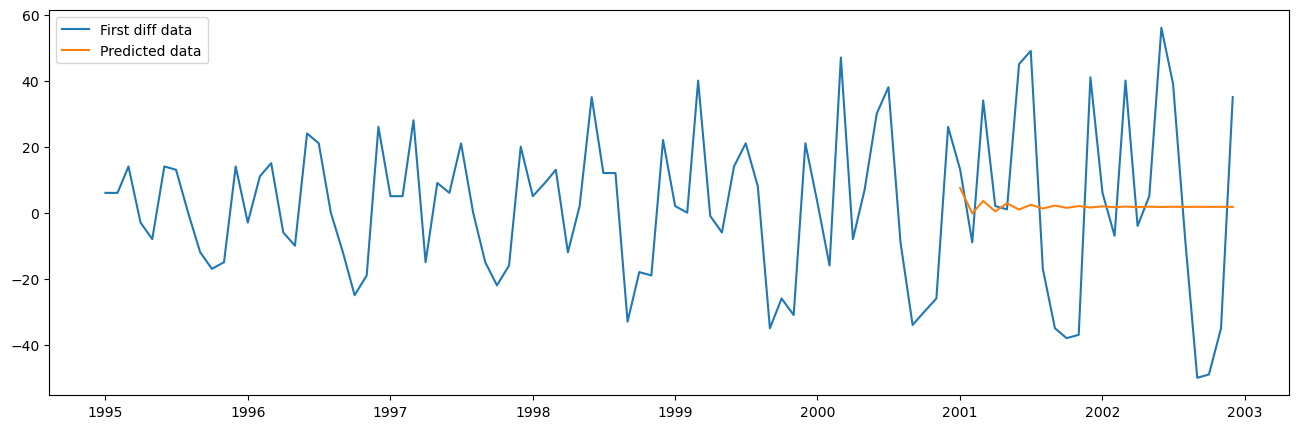

In [58]:
plt.figure(figsize=(16,5))
plt.plot(df['diff_1'],label='First diff data')
plt.plot(pred, label='Predicted data')
plt.legend()
plt.show()

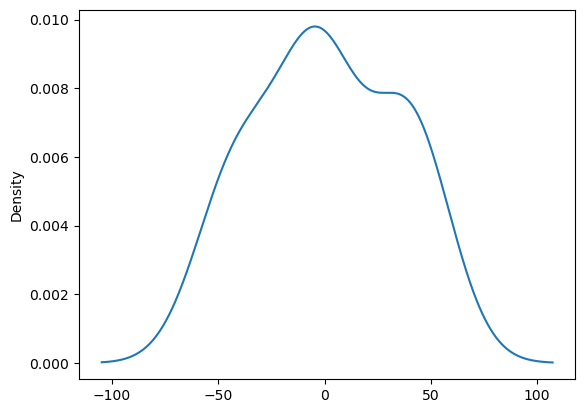

In [59]:
residuals = test_df_diff_1 - pred
residuals.plot(kind='kde')
plt.show()

* Looks like residuals normally distributed

In [60]:
mae_arima_diff_1 = mean_absolute_error(test_df_diff_1,pred)
rmse_arima_diff_1 = np.sqrt(mean_squared_error(test_df_diff_1, pred))
mae_arima_diff_1, rmse_arima_diff_1

(26.90481759975116, 32.422098734639334)

In [61]:
model = ARIMA(train_df_diff_2, order=(2,1,2)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

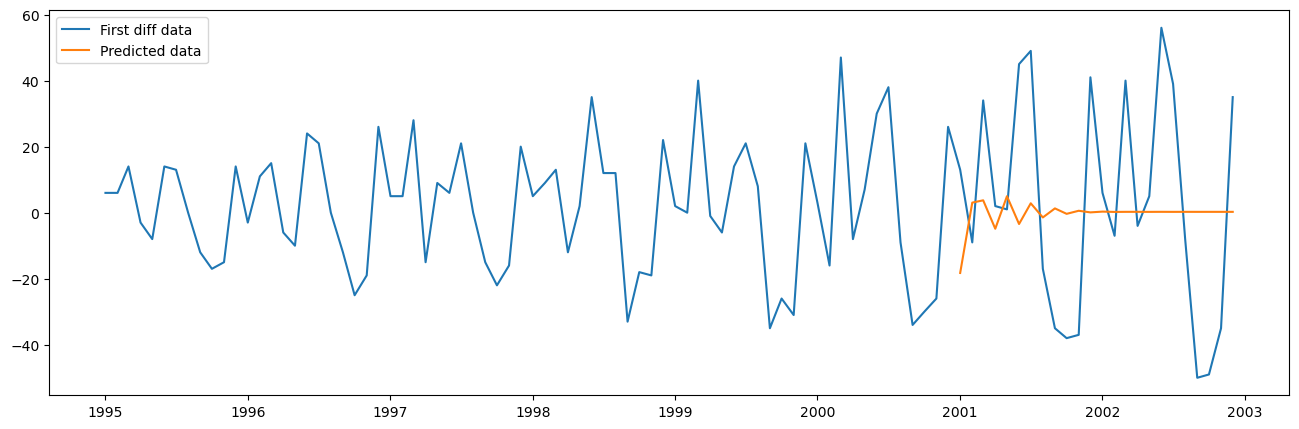

In [62]:
plt.figure(figsize=(16,5))
plt.plot(df['diff_1'],label='First diff data')
plt.plot(pred, label='Predicted data')
plt.legend()
plt.show()

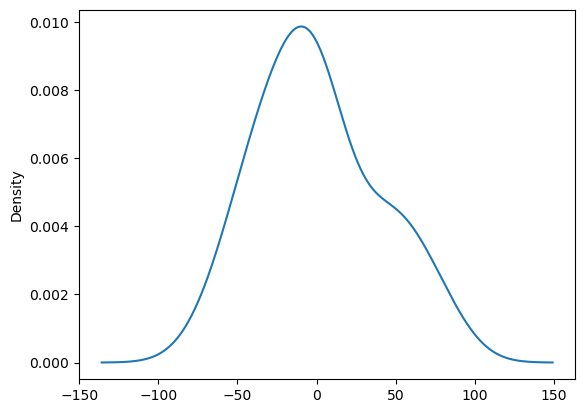

In [63]:
residuals = test_df_diff_2 - pred
residuals.plot(kind='kde')
plt.show()

In [65]:
mae_arima_diff_2 = mean_absolute_error(test_df_diff_2,pred)
rmse_arima_diff_2 = np.sqrt(mean_squared_error(test_df_diff_2, pred))
mae_arima_diff_2, rmse_arima_diff_2

(29.422329872337105, 37.31833391967806)

### Build model with whole dataset

In [66]:
model = ARIMA(df['Passengers'], order=(5,1,0)).fit()
pred = model.predict(start=len(df),end=len(df)+12)
pred

2003-01-01    342.312578
2003-02-01    357.313087
2003-03-01    360.677928
2003-04-01    344.344903
2003-05-01    328.166895
2003-06-01    324.597779
2003-07-01    327.710820
2003-08-01    335.195904
2003-09-01    341.127309
2003-10-01    341.237806
2003-11-01    338.400383
2003-12-01    335.188884
2004-01-01    333.421323
Freq: MS, Name: predicted_mean, dtype: float64

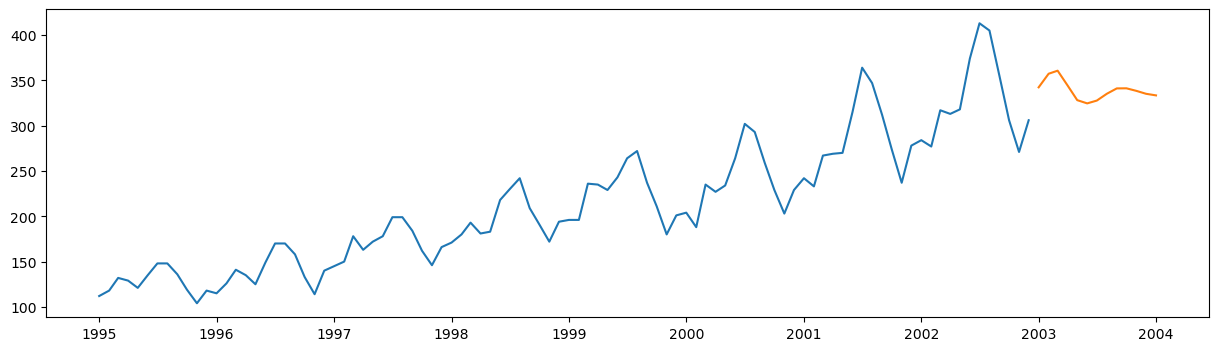

In [67]:
plt.figure(figsize=(15,4))
plt.plot(df['Passengers'])
plt.plot(pred)
plt.show()

## 5.3. SARIMAX

In [68]:
model = SARIMAX(train_df_pas, order=(2,1,2), seasonal=(2,1,1,5)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

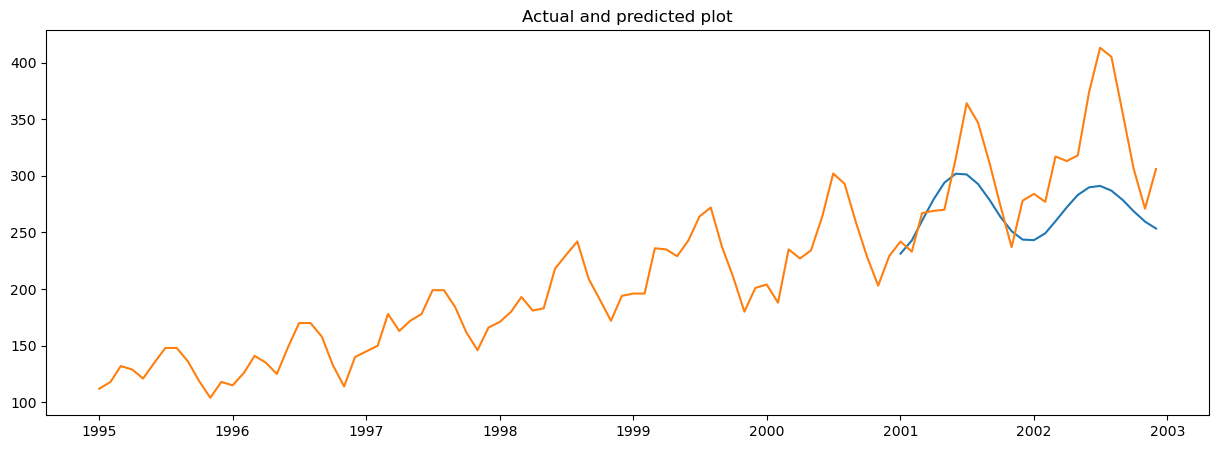

In [69]:
plt.figure(figsize=(15,5))
plt.plot(pred)
plt.title('Actual and predicted plot')
plt.plot(df['Passengers'])
plt.show()

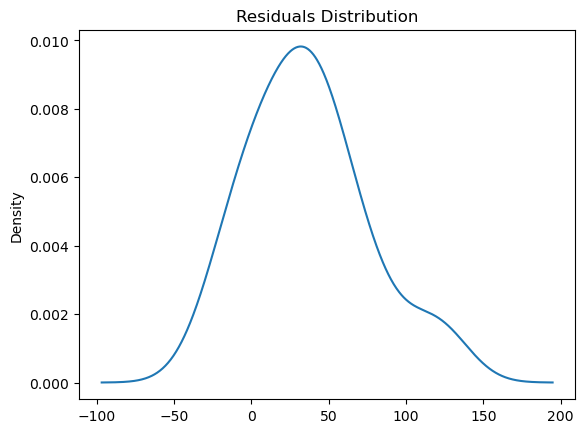

In [70]:
residuals = test_df_pas - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [71]:
mae_sarimax_actual = mean_absolute_error(test_df_pas,pred)
rmse_sarimax_actual = np.sqrt(mean_squared_error(test_df_pas, pred))
mae_sarimax_actual, rmse_sarimax_actual

(41.099358619818055, 52.11704560080698)

In [72]:
model = SARIMAX(train_df_diff_1, order=(2,1,2), seasonal=(2,1,1,50)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

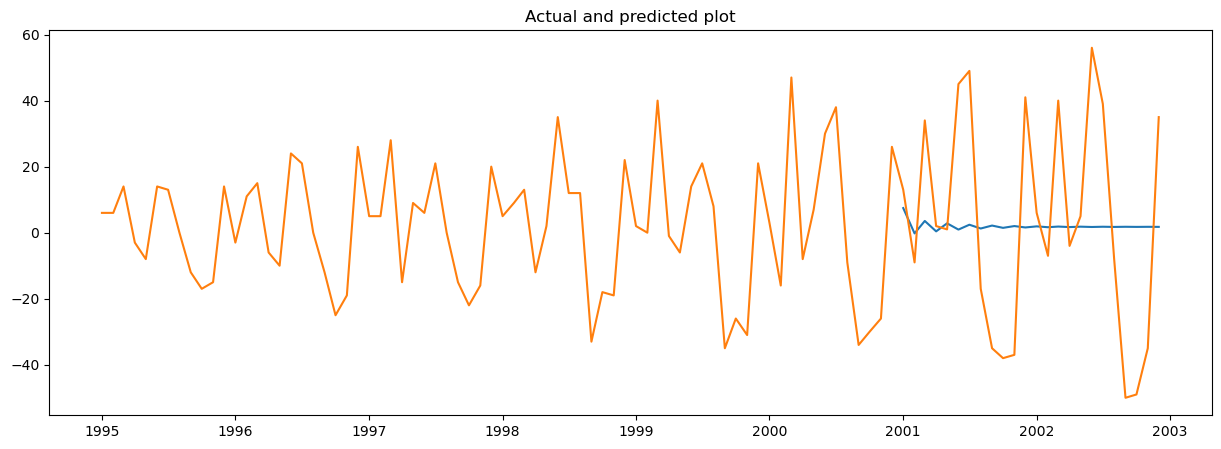

In [73]:
plt.figure(figsize=(15,5))
plt.plot(pred)
plt.title('Actual and predicted plot')
plt.plot(df['diff_1'])
plt.show()

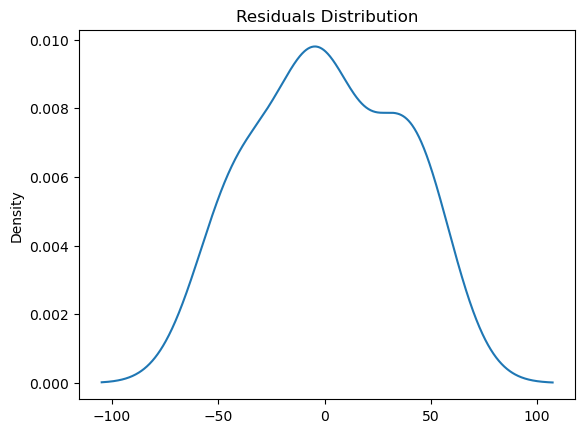

In [74]:
residuals = test_df_diff_1 - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [75]:
mae_sarimax_diff_1 = mean_absolute_error(test_df_diff_1,pred)
rmse_sarimax_diff_1 = np.sqrt(mean_squared_error(test_df_diff_1, pred))
mae_sarimax_diff_1, rmse_sarimax_diff_1

(26.90481759975116, 32.422098734639334)

In [76]:
model = SARIMAX(train_df_diff_2, order=(2,1,2), seasonal=(2,1,1,50)).fit()
pred = model.predict(start=train_len, end=len(df)-1)

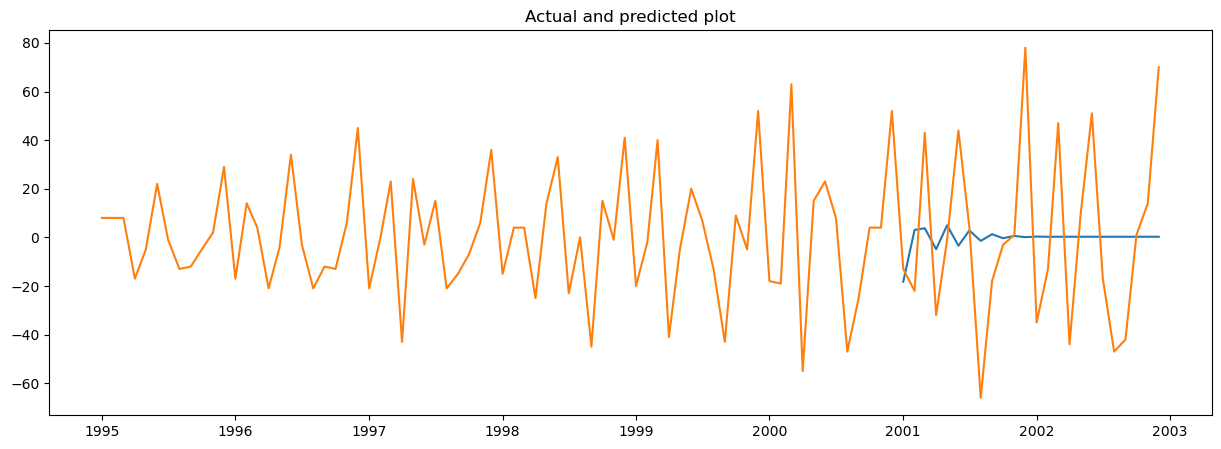

In [77]:
plt.figure(figsize=(15,5))
plt.plot(pred)
plt.title('Actual and predicted plot')
plt.plot(df['diff_2'])
plt.show()

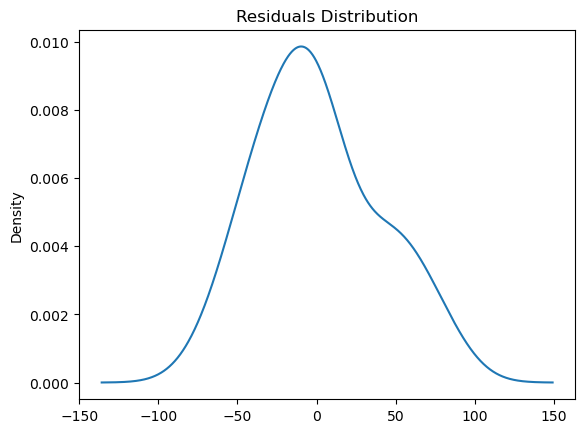

In [78]:
residuals = test_df_diff_2 - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [80]:
mae_sarimax_diff_2 = mean_absolute_error(test_df_diff_2,pred)
rmse_sarimax_diff_2 = np.sqrt(mean_squared_error(test_df_diff_2, pred))
mae_sarimax_diff_2, rmse_sarimax_diff_2

(29.422329872337105, 37.31833391967806)

In [81]:
df1 = pd.read_excel('Airlines+Data.xlsx')

In [82]:
df1.head() 

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [83]:
df1 = pd.get_dummies(df1)
df1.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [84]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [85]:
df1['Month_exd'] = df1['Month'].dt.month

In [86]:
df2 = pd.get_dummies(df1.drop(columns='Month'),columns=['Month_exd'])

In [87]:
df2.head()

,Passengers,Month_exd_1,Month_exd_2,Month_exd_3,Month_exd_4,Month_exd_5,Month_exd_6,Month_exd_7,Month_exd_8,Month_exd_9,Month_exd_10,Month_exd_11,Month_exd_12
0,112,1,0,0,0,0,0,0,0,0,0,0,0
1,118,0,1,0,0,0,0,0,0,0,0,0,0
2,132,0,0,1,0,0,0,0,0,0,0,0,0
3,129,0,0,0,1,0,0,0,0,0,0,0,0
4,121,0,0,0,0,1,0,0,0,0,0,0,0


In [88]:
train_df = df2.iloc[:train_len,:]
test_df = df2.iloc[train_len:,:]

## 5.4. OLS Model

In [89]:
df2.columns

Index(['Passengers', 'Month_exd_1', 'Month_exd_2', 'Month_exd_3',
       'Month_exd_4', 'Month_exd_5', 'Month_exd_6', 'Month_exd_7',
       'Month_exd_8', 'Month_exd_9', 'Month_exd_10', 'Month_exd_11',
       'Month_exd_12'],
      dtype='object')

In [90]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [91]:
model = smf.ols('Passengers~Month_exd_1+Month_exd_2+Month_exd_3+Month_exd_4+Month_exd_5+Month_exd_6+Month_exd_7+Month_exd_8+Month_exd_9+Month_exd_10+Month_exd_11+Month_exd_12',data=train_df).fit()

In [92]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.379
Date:                Wed, 12 Jul 2023   Prob (F-statistic):              0.206
Time:                        12:31:53   Log-Likelihood:                -371.83
No. Observations:                  72   AIC:                             767.7
Df Residuals:                      60   BIC:                             795.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      168.8333      5.044     33.475      0.000     158.745     178.922
Month_exd_1    -11.6667     18.126     -0.644      0.522     -47.925      24.591
Month_exd_2     -9.1667     18.126     -0.506      0.615     -45.425      27.091
Month_exd_3     17.0000     18.126      0.938      0.352     -19.258      53.258
Month_exd_4      9.5000     18.126      0.524      0.602     -26.758      45.758
Month_exd_5      8.5000     18.126      0.469      0.641     -27.758      44.758
Month_exd_6     29.0000     18.126      1.600      0.115      -7.258      65.258
Month_exd_7     50.0000     18.126      2.758      0.008      13.742      86.258
Month_exd_8     51.8333     18.126      2.860      0.006      15.575      88.091
Month_exd_9     28.3333     18.126      1.563      0.123      -7.925      64.591
Month_exd_10     5.3333     18.126      0.294      0.770     -30.925      41.591
Month_exd_11   -15.6667     18.126     -0.864      0.391     -51.925      20.591
Month_exd_12     5.8333     18.126      0.322      0.749     -30.425      42.091
==============================================================================
Omnibus:                       29.671   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.962
Skew:                           0.033   Prob(JB):                       0.0837
Kurtosis:                       1.716   Cond. No.                     1.61e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 5.5. Simple Exponential Smoothing

In [93]:
df.head(2)

,Passengers,diff_1,diff_2
Month,,,
1995-01-01,112,6.0,8.0
1995-02-01,118,6.0,8.0


In [94]:
train_len = int(len(df)*0.75)
test_len = len(df)-train_len

In [95]:
train_data = df.iloc[:train_len,]
test_data = df.iloc[train_len:,]

In [96]:
ses = SimpleExpSmoothing(train_data['Passengers']).fit(smoothing_level=0.2)
pred = ses.forecast(test_len)

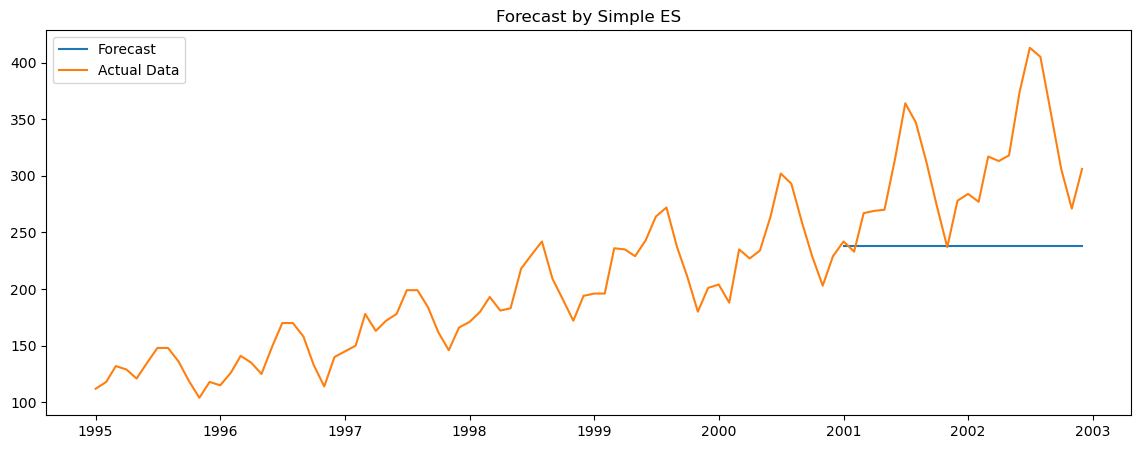

In [97]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['Passengers'],label='Actual Data')
plt.title('Forecast by Simple ES')
plt.legend()
plt.show()

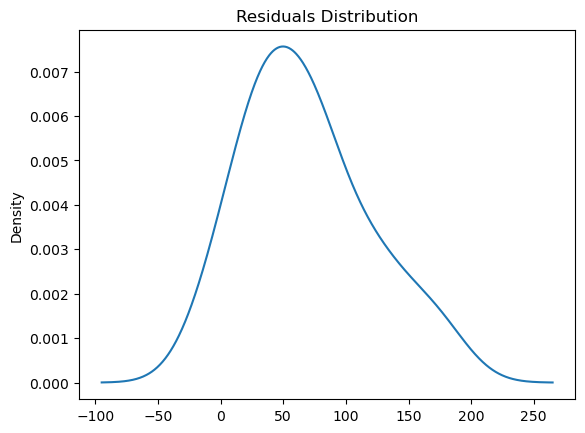

In [98]:
residuals = test_data['Passengers'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [99]:
mae_ses_a_actual = mean_absolute_error(test_data['Passengers'], pred)
rmse_ses_a_actual = np.sqrt(mean_squared_error(test_df_pas, pred))
mae_ses_a_actual, rmse_ses_a_actual

(68.64644222306582, 83.65334103034091)

In [146]:
ses = SimpleExpSmoothing(train_data['diff_1']).fit(smoothing_level=0.2)
pred = ses.forecast(test_len)

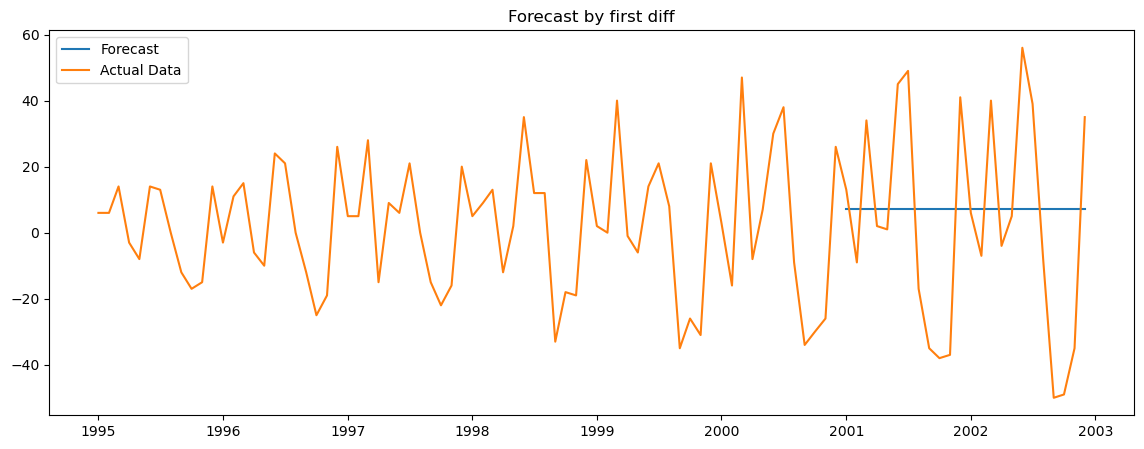

In [152]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['diff_1'],label='Actual Data')
plt.title('Forecast by first diff')
plt.legend()
plt.show()

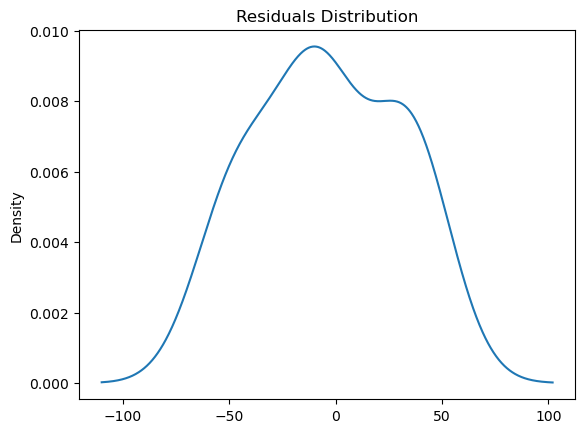

In [154]:
residuals = test_data['diff_1'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [100]:
mae_ses_a_diff_1 = mean_absolute_error(test_data['diff_1'], pred)
rmse_ses_a_diff_1 = np.sqrt(mean_squared_error(test_data['diff_1'], pred))
mae_ses_a_diff_1, rmse_ses_a_diff_1

(234.76593599898766, 237.00888092229022)

In [156]:
ses = SimpleExpSmoothing(train_data['diff_2']).fit(smoothing_level=0.2)
pred = ses.forecast(test_len)

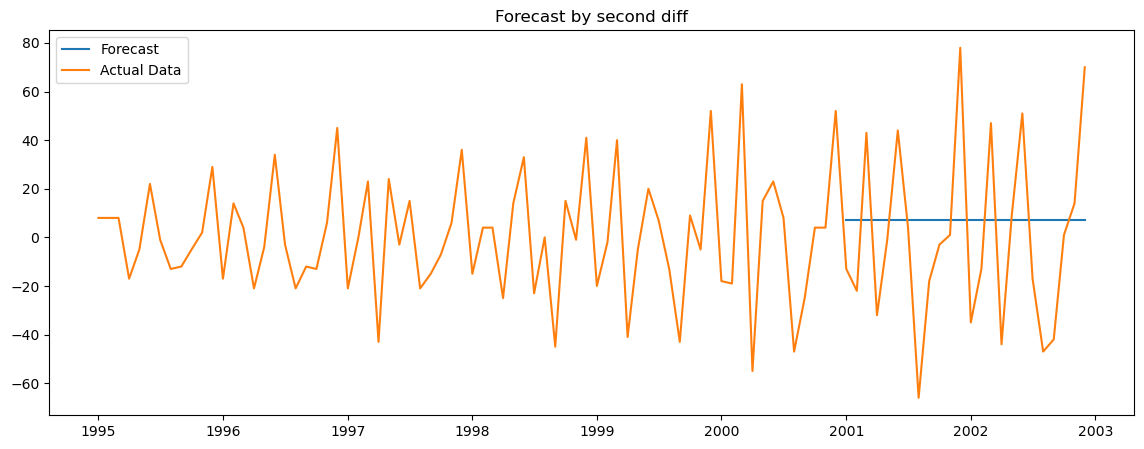

In [157]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['diff_2'],label='Actual Data')
plt.title('Forecast by second diff')
plt.legend()
plt.show()

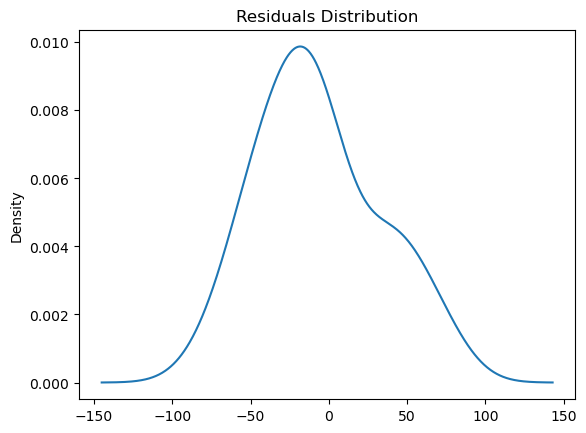

In [158]:
residuals = test_data['diff_2'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [101]:
mae_ses_a_diff_2 = mean_absolute_error(test_data['diff_2'], pred)
rmse_ses_a_diff_2 = np.sqrt(mean_squared_error(test_data['diff_2'], pred))
mae_ses_a_diff_2, rmse_ses_a_diff_2

(237.599269332321, 240.5472521056646)

## 5.6. Double Exponential Smoothing with Additive trend

In [102]:
ses = ExponentialSmoothing(train_data['Passengers'], trend = 'add').fit()
pred = ses.forecast(test_len)

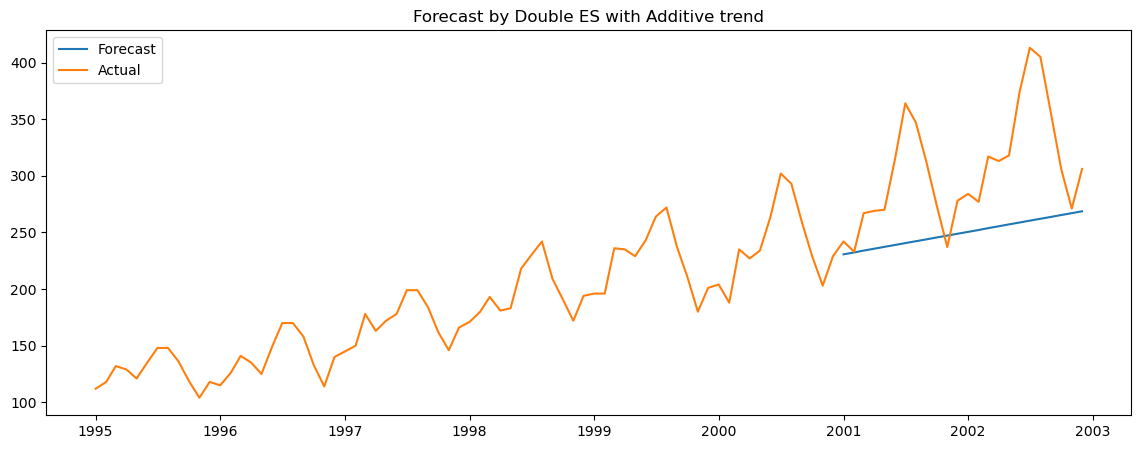

In [103]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['Passengers'],label='Actual')
plt.title('Forecast by Double ES with Additive trend')
plt.legend()
plt.show()

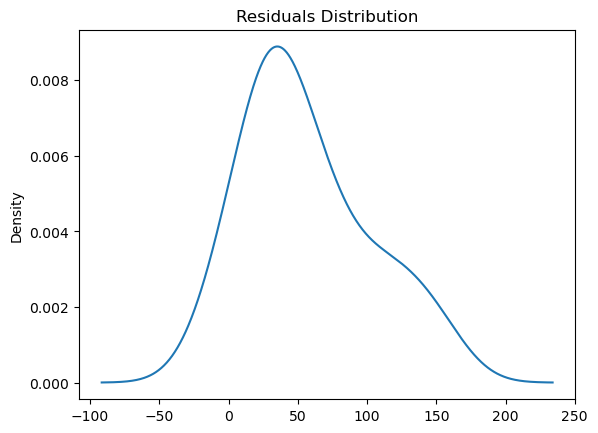

In [104]:
residuals = test_data['Passengers'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [105]:
mae_des_a_actual = mean_absolute_error(test_data['Passengers'], pred)
rmse_des_a_actual = np.sqrt(mean_squared_error(test_data['Passengers'], pred))
mae_des_a_actual, rmse_des_a_actual

(57.32656323228076, 71.59298246658335)

In [106]:
ses = ExponentialSmoothing(train_data['diff_1'], trend = 'add').fit()
pred = ses.forecast(test_len)

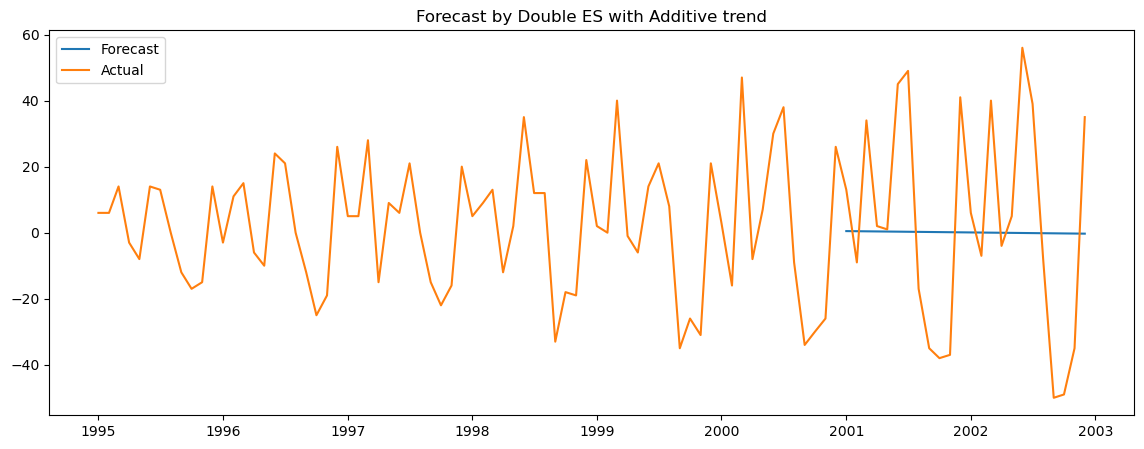

In [107]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['diff_1'],label='Actual')
plt.title('Forecast by Double ES with Additive trend')
plt.legend()
plt.show()

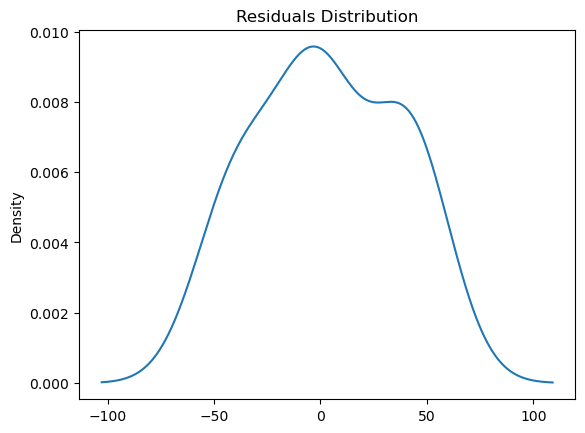

In [108]:
residuals = test_data['diff_1'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [109]:
mae_des_a_diff1 = mean_absolute_error(test_data['diff_1'], pred)
rmse_des_a_diff_1 = np.sqrt(mean_squared_error(test_data['diff_1'], pred))
mae_des_a_diff1, rmse_des_a_diff_1

(27.23205086666287, 32.64100122628471)

In [110]:
ses = ExponentialSmoothing(train_data['diff_2'], trend = 'add').fit()
pred = ses.forecast(test_len)

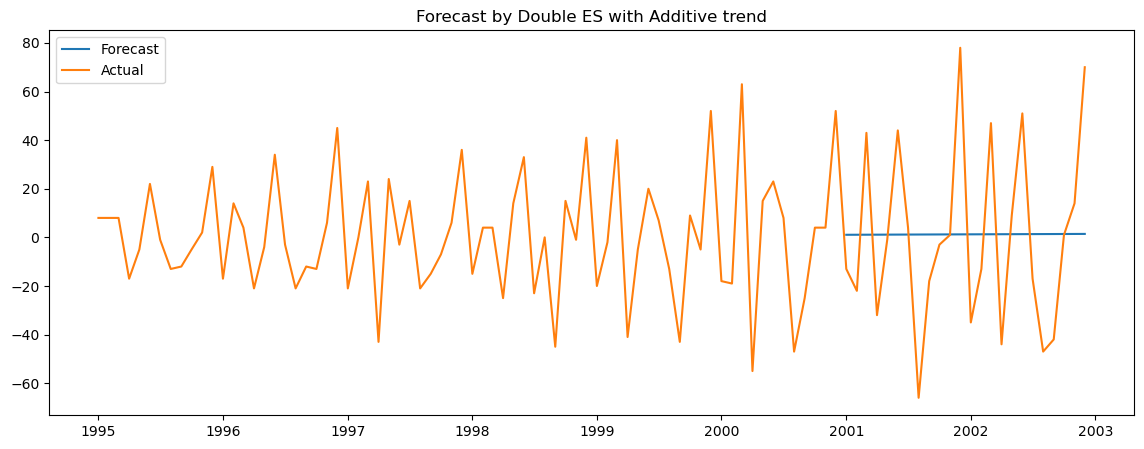

In [111]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['diff_2'], label='Actual')
plt.title('Forecast by Double ES with Additive trend')
plt.legend()
plt.show()

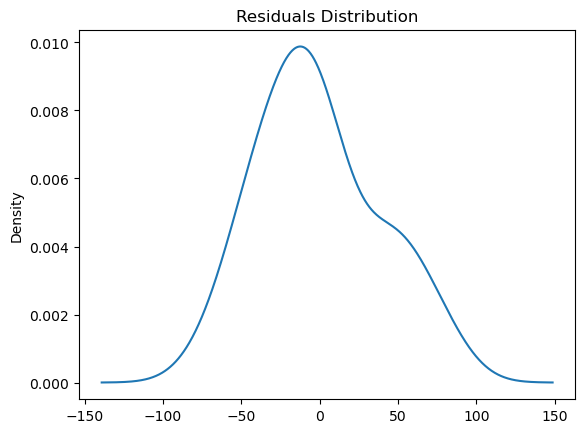

In [112]:
residuals = test_data['diff_2'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [114]:
mae_des_a_diff_2 = mean_absolute_error(test_data['diff_2'], pred)
rmse_des_a_diff_2 = np.sqrt(mean_squared_error(test_data['diff_2'], pred))
mae_des_a_diff_2

29.918747794948533

## 5.7. Double Exponential Smoothing with Multiplicative trend

In [115]:
tse = ExponentialSmoothing(train_data['Passengers'], trend = 'mul').fit()
pred = tse.forecast(test_len)

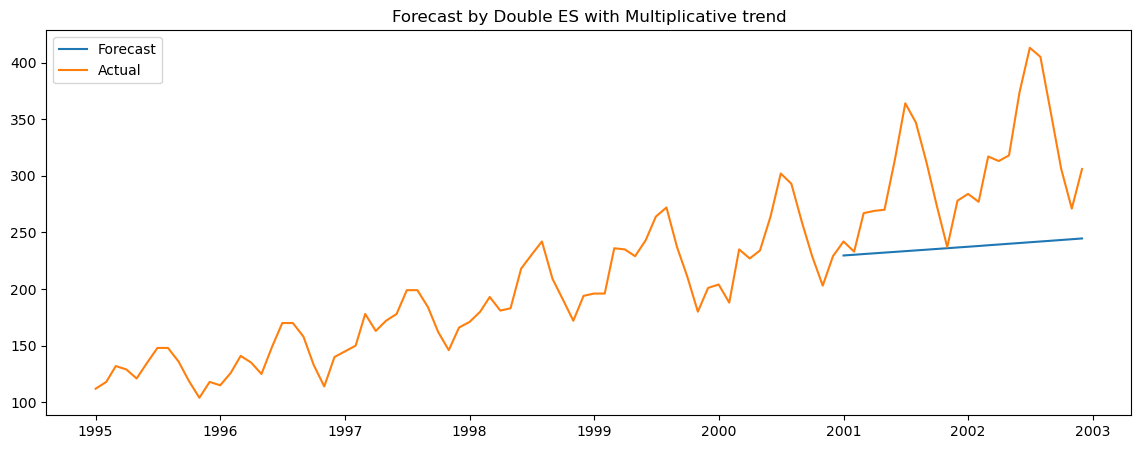

In [116]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['Passengers'], label='Actual')
plt.title('Forecast by Double ES with Multiplicative trend')
plt.legend()
plt.show()

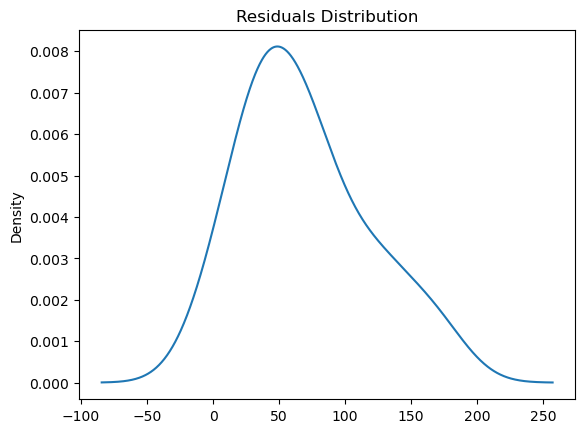

In [117]:
residuals = test_data['Passengers'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [123]:
mae_tse_m_actual = mean_absolute_error(test_data['Passengers'], pred)
rmse_tse_m_actual = np.sqrt(mean_squared_error(test_data['Passengers'], pred))
mae_tse_m_actual, rmse_tse_m_actual

(39.88172496272874, 47.5692832638379)

## 5.8. Triple Exponential Smoothing

In [124]:
tse_a_a = ExponentialSmoothing(train_data['Passengers'], trend = 'add', seasonal = 'add').fit()
pred = tse_a_a.forecast(test_len)

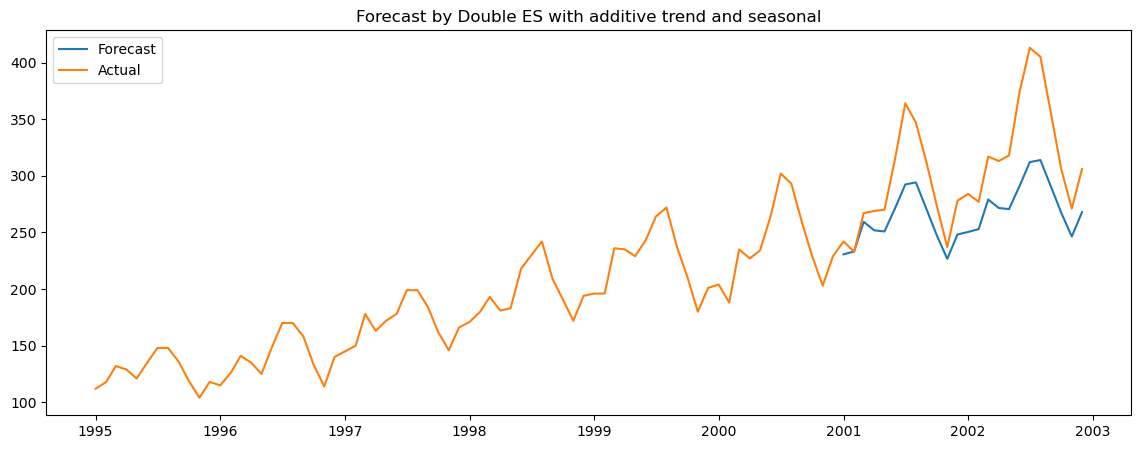

In [125]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast')
plt.plot(df['Passengers'], label='Actual')
plt.title('Forecast by Double ES with additive trend and seasonal')
plt.legend()
plt.show()

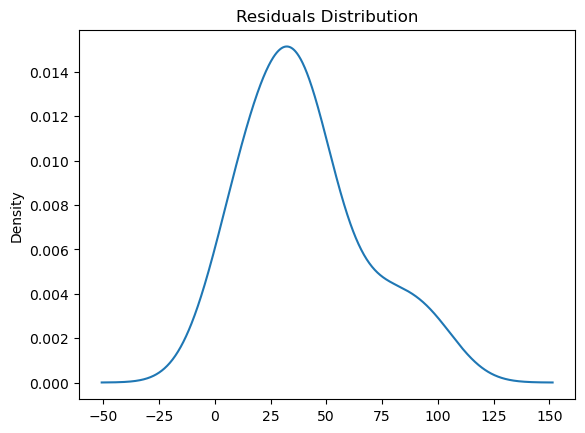

In [126]:
residuals = test_data['Passengers'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [134]:
mae_tse_a_a_actual = mean_absolute_error(test_data['Passengers'], pred)
rmse_tse_a_a_actual = np.sqrt(mean_squared_error(test_data['Passengers'], pred))
mae_tse_a_a_actual, rmse_tse_a_a_actual

(304.0642648073636, 307.66936174262446)

In [130]:
tse_a_a = ExponentialSmoothing(train_data['diff_1'], trend = 'add', seasonal = 'add').fit()
pred = tse_a_a.forecast(test_len)

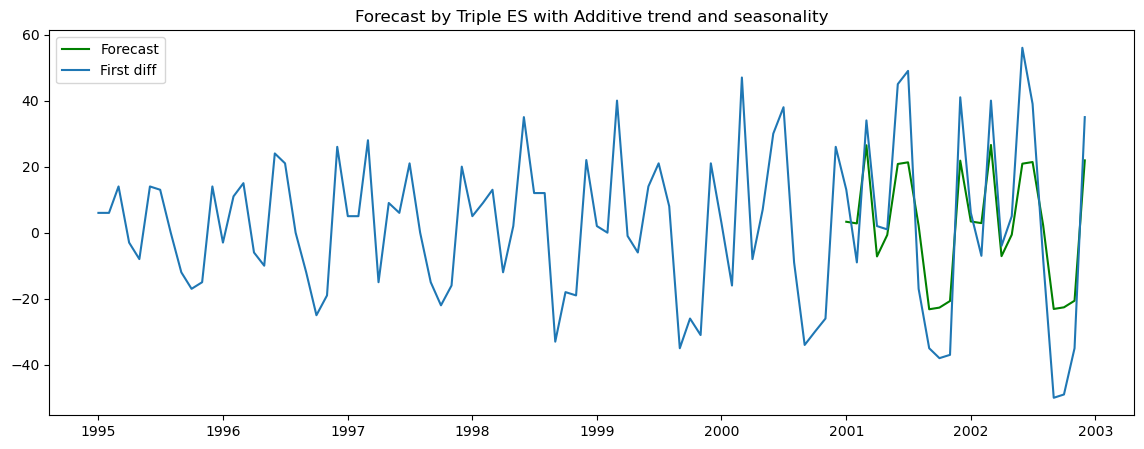

In [131]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast',color='green')
plt.plot(df['diff_1'], label='First diff')
plt.title('Forecast by Triple ES with Additive trend and seasonality')
plt.legend()
plt.show()

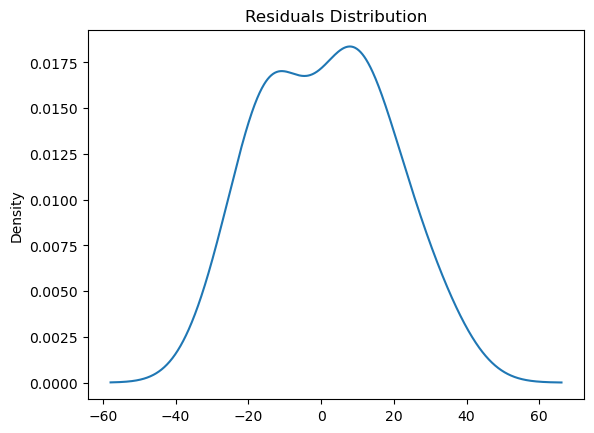

In [132]:
residuals = test_data['diff_1'] - pred
residuals.plot(kind='kde')
plt.title('Residuals Distribution')
plt.show()

In [135]:
mae_tes_a_a_diff_1 = mean_absolute_error(test_data['diff_1'],pred)
rmse_tse_a_a_diff_1 = np.sqrt(mean_squared_error(test_data['diff_1'], pred))
mae_tes_a_a_diff_1, rmse_tse_a_a_diff_1

(14.663471581944165, 16.926401317627423)

In [136]:
tse_a_a = ExponentialSmoothing(train_data['diff_2'], trend = 'add', seasonal = 'add').fit()
pred = tse_a_a.forecast(test_len)

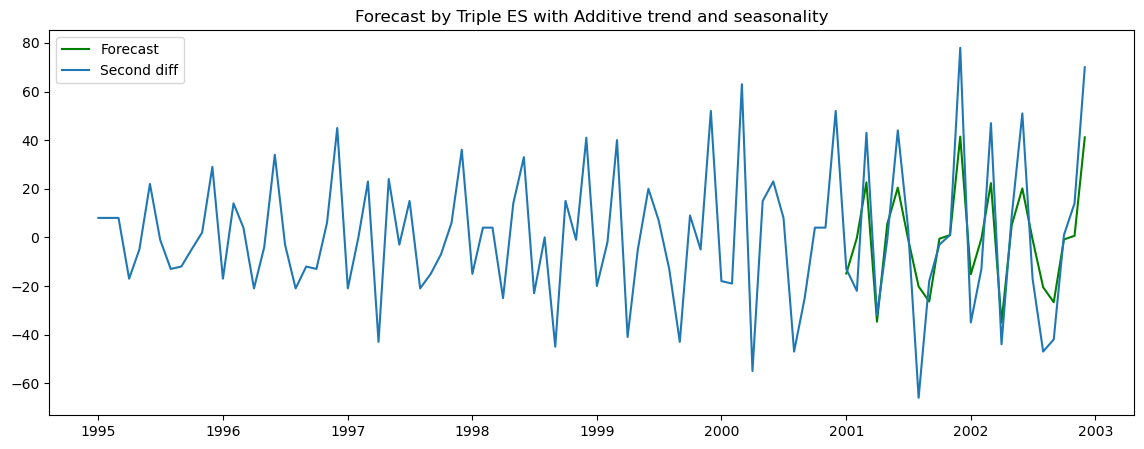

In [137]:
plt.figure(figsize=(14,5))
plt.plot(pred, label='Forecast', color='green')
plt.plot(df['diff_2'], label='Second diff')
plt.title('Forecast by Triple ES with Additive trend and seasonality')
plt.legend()
plt.show()

In [138]:
mae_tes_a_a_diff_2 = mean_absolute_error(test_data['diff_2'],pred)
rmse_tse_a_a_diff_2 = np.sqrt(mean_squared_error(test_data['diff_2'], pred))
mae_tes_a_a_diff_2, rmse_tse_a_a_diff_2

(15.716585606082836, 19.834633457414288)

# 6. Model Selection 

In [145]:
metrics = pd.DataFrame([[rmse_ar_diff_1, rmse_ar_diff_2, rmse_ar_actual,mae_ar_diff_1, mae_ar_diff_2, mae_ar_actual],
                        [rmse_arima_diff_1, rmse_arima_diff_2, rmse_arima_actual,rmse_arima_diff_1, mae_arima_diff_2, mae_arima_actual],
                        [rmse_sarimax_diff_1, rmse_sarimax_diff_2, rmse_sarimax_actual, mae_sarimax_diff_1, mae_sarimax_diff_2, mae_sarimax_actual],
                        [rmse_ses_a_diff_1, rmse_ses_a_diff_2, rmse_ses_a_actual, mae_ses_a_diff_1, mae_ses_a_diff_2, mae_ses_a_actual],
                        [rmse_des_a_diff_1, rmse_des_a_diff_2, rmse_des_a_actual, mae_des_a_diff1, mae_des_a_diff_2, mae_des_a_actual],
                        [np.nan, np.nan, rmse_tse_m_actual ,np.nan, np.nan, mae_tse_m_actual],
                        [rmse_tse_a_a_diff_1, rmse_tse_a_a_diff_2, rmse_tse_a_a_actual ,mae_tes_a_a_diff_1, mae_tes_a_a_diff_2, mae_tse_a_a_actual]],
                       columns=['diff_1_RMSE','diff_2_RMSE', 'Actual_RMSE' ,'diff_1_MAE','diff_2_MAE', 'Actual_MAE'],
                       index=['AR','ARIMA','SARIMAX','Simple ES','Double ES with Additive trend',
                              'Double ES with Multiplicative trend','Triple ES'])

In [150]:
metrics.sort_values('diff_1_RMSE')

,diff_1_RMSE,diff_2_RMSE,Actual_RMSE,diff_1_MAE,diff_2_MAE,Actual_MAE
Triple ES,16.926401,19.834633,307.669362,14.663472,15.716586,304.064265
ARIMA,32.422099,37.318334,308.085122,32.422099,29.422330,304.126658
SARIMAX,32.422099,37.318334,52.117046,26.904818,29.422330,41.099359
AR,32.634783,38.059186,108.476020,27.257210,30.682435,94.045788
Double ES with Additive trend,32.641001,37.543037,47.569283,27.232051,29.918748,57.326563
Simple ES,237.008881,240.547252,83.653341,234.765936,237.599269,68.646442
Double ES with Multiplicative trend,NaN,NaN,47.569283,NaN,NaN,39.881725


In [151]:
metrics.sort_values('diff_2_RMSE')

,diff_1_RMSE,diff_2_RMSE,Actual_RMSE,diff_1_MAE,diff_2_MAE,Actual_MAE
Triple ES,16.926401,19.834633,307.669362,14.663472,15.716586,304.064265
ARIMA,32.422099,37.318334,308.085122,32.422099,29.422330,304.126658
SARIMAX,32.422099,37.318334,52.117046,26.904818,29.422330,41.099359
Double ES with Additive trend,32.641001,37.543037,47.569283,27.232051,29.918748,57.326563
AR,32.634783,38.059186,108.476020,27.257210,30.682435,94.045788
Simple ES,237.008881,240.547252,83.653341,234.765936,237.599269,68.646442
Double ES with Multiplicative trend,NaN,NaN,47.569283,NaN,NaN,39.881725


In [152]:
metrics.sort_values('Actual_RMSE')

,diff_1_RMSE,diff_2_RMSE,Actual_RMSE,diff_1_MAE,diff_2_MAE,Actual_MAE
Double ES with Additive trend,32.641001,37.543037,47.569283,27.232051,29.918748,57.326563
Double ES with Multiplicative trend,NaN,NaN,47.569283,NaN,NaN,39.881725
SARIMAX,32.422099,37.318334,52.117046,26.904818,29.422330,41.099359
Simple ES,237.008881,240.547252,83.653341,234.765936,237.599269,68.646442
AR,32.634783,38.059186,108.476020,27.257210,30.682435,94.045788
Triple ES,16.926401,19.834633,307.669362,14.663472,15.716586,304.064265
ARIMA,32.422099,37.318334,308.085122,32.422099,29.422330,304.126658


# Conclusion
* Preprocessing of data
1. I plotted the data and it is found to be seasonal and upward trend.
2. I have checked stationary of data by ADFuller test. I got data is Non-Stationary.
3. I did first differencing then check stationary of data by ADFuller test and got data is now changed Non-stationary to Stationary,
4. After I did second differencing for better result.
* I have build different time series models and I got different results.
1. AR gives the less mean absolute error among all the models.
2. Triple exponential gives the best fit or I can say able to predict the pattern.
3. Double ES with Multiplicative trend performed well with Actual data.
4. Triple ES performed well with differencing data.